##RTI Data Challenge
This notebook is in reference to the following challenge: https://github.com/rtidatascience/exercises/tree/master/exercise01

###Task 1:
**Write a SQL query that creates a consolidated dataset from the normalized tables in the database. In other words, write a SQL query that "flattens" the database to a single table.**

First things first, let's initialize our connection to the SQLite DB we were provided with.

In [1]:
#Initialize Connection to SQLite Database
import sqlite3
sqlite_file = 'exercise01.sqlite'
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

Next, we need to do some exploration of the SQLite database to help us understand how to create our flat file.  We can use the code below to figure out how our database has been set up.

In [2]:
#This Code Tells me the Column Names in the SQLite Master Table
c.execute("SELECT * FROM sqlite_master;")
column_names = [description[0] for description in c.description]
print column_names

['type', 'name', 'tbl_name', 'rootpage', 'sql']


Using the above output, we can write a query that shows how each of the database tables were created.  This way, we will be able to figure out how the data needs to be joined to eventually create our flat file.

In [3]:
#Prints the sql column shown above
c.execute("SELECT tbl_name, sql FROM sqlite_master where type = 'table';")
for object in c.fetchall():
    print 'Table Name: ' + object[0]
    print object[1]

Table Name: workclasses
CREATE TABLE workclasses (
	id INTEGER NOT NULL, name TEXT, 
	PRIMARY KEY (id)
)
Table Name: education_levels
CREATE TABLE education_levels (
	id INTEGER NOT NULL, name TEXT, 
	PRIMARY KEY (id)
)
Table Name: marital_statuses
CREATE TABLE marital_statuses (
	id INTEGER NOT NULL, name TEXT, 
	PRIMARY KEY (id)
)
Table Name: occupations
CREATE TABLE occupations (
	id INTEGER NOT NULL, name TEXT, 
	PRIMARY KEY (id)
)
Table Name: relationships
CREATE TABLE relationships (
	id INTEGER NOT NULL, name TEXT, 
	PRIMARY KEY (id)
)
Table Name: races
CREATE TABLE races (
	id INTEGER NOT NULL, name TEXT, 
	PRIMARY KEY (id)
)
Table Name: sexes
CREATE TABLE sexes (
	id INTEGER NOT NULL, name TEXT, 
	PRIMARY KEY (id)
)
Table Name: countries
CREATE TABLE countries (
	id INTEGER NOT NULL, name TEXT, 
	PRIMARY KEY (id)
)
Table Name: records
CREATE TABLE records (
	id INTEGER NOT NULL, age INTEGER, workclass_id INTEGER, education_level_id INTEGER, education_num INTEGER, marital_statu

It looks like the "**records**" table should be our starting point, so let's read it into Pandas.

In [4]:
#Read 'records' database table into a Pandas DataFrame
import pandas as pd
records = pd.read_sql_query("SELECT * FROM records;", conn, index_col='id')
records.head()

,age,workclass_id,education_level_id,education_num,marital_status_id,occupation_id,relationship_id,race_id,sex_id,capital_gain,capital_loss,hours_week,country_id,over_50k
id,,,,,,,,,,,,,,
1,39,8,10,13,5,2,2,5,2,2174,0,40,40,0
2,50,7,10,13,3,5,1,5,2,0,0,13,40,0
3,38,5,12,9,1,7,2,5,2,0,0,40,40,0
4,53,5,2,7,3,7,1,3,2,0,0,40,40,0
5,28,5,10,13,3,11,6,3,1,0,0,40,6,0


Now let's talk about joins. The columns ending in "**_id**" above are foreign keys that correspond to other tables in the database that contain the values associated with that categorical variable.  Below is an example for the column "**workclass_id**."

In [5]:
#Examine structure of 'workclasses' database table
workclasses = pd.read_sql_query("SELECT * FROM workclasses;", conn, index_col='id')
workclasses.head()

,name
id,
1,?
2,Federal-gov
3,Local-gov
4,Never-worked
5,Private


So, now that we know how that works.  Here is the code to create our master flat file, applying this same idealogy to all of the tables in our DB.

In [6]:
#Create "flattened" table
records_joined = pd.read_sql_query("""
    SELECT records.id,
        records.age,
        workclasses.name as workclass, 
        education_levels.name as education_level, 
        education_num, 
        marital_statuses.name as marital_status,
        occupations.name as occupation,
        relationships.name as relationship,
        races.name as race,
        sexes.name as sex,
        countries.name as country,
        records.capital_gain,
        records.capital_loss,
        records.hours_week,
        records.over_50k
    FROM records 
    JOIN workclasses ON records.workclass_id = workclasses.id
    JOIN education_levels ON records.education_level_id = education_levels.id
    JOIN marital_statuses ON records.marital_status_id = marital_statuses.id
    JOIN occupations ON records.occupation_id = occupations.id
    JOIN relationships ON records.relationship_id = relationships.id
    JOIN races ON records.race_id = races.id
    JOIN sexes ON records.sex_id = sexes.id
    JOIN countries ON records.country_id = countries.id;""", conn, index_col='id')
records_joined.head()

,age,workclass,education_level,education_num,marital_status,occupation,relationship,race,sex,country,capital_gain,capital_loss,hours_week,over_50k
id,,,,,,,,,,,,,,
1,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,2174,0,40,0
2,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,0,0,13,0
3,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,0,0,40,0
4,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,0,0,40,0
5,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,0,0,40,0


###Tasks 2 & 3:
**Export the "flattened" table to a CSV file and import the "flattened" table (or CSV file) into your open source analytic environment of choice (R, Python, Java, etc.) and stage it for analysis.**

Well, since we worked with the SQLite API in Python, we don't actually have to do these steps because we already have our data ready to go.  Go us!  But if we *did* need to write this file to a CSV, or read this file from a CSV, we could do that as follows.

In [7]:
#When uncommented, this code writes the DataFrame to csv in the directory
#records_joined.to_csv('records_joined.csv')

#When uncommented, this code reads the csv file to a DataFrame
#records_joined = pd.read_csv('records_joined.csv', index_col='id')

###Task 4:
**Perform some simple exploratory analysis and generate summary statistics to get a sense of what is in the data.**

We will use our exploratory analysis to get familiar with our data, but also to start deciding which variables will make good features for the model we will eventually build.  In this secion, we will look at all variables in our "flattened" table--both numeric and categorical--and see what insights we can draw.

In [8]:
#Descriptive Statistics of Numeric Variables
records_joined.describe()

,age,education_num,capital_gain,capital_loss,hours_week,over_50k
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,10.078089,1079.067626,87.502314,40.422382,0.239282
std,13.710510,2.570973,7452.019058,403.004552,12.391444,0.426649
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000


The above chart shows some of the most popular quantile measures for each *numeric* variable.  Based on the above, it appears that **23.9%** of individuals in our sample make over $50,000 annually.  Let's take a look at that in graphic form.  We can easily put together a quick bar chart using seaborn.

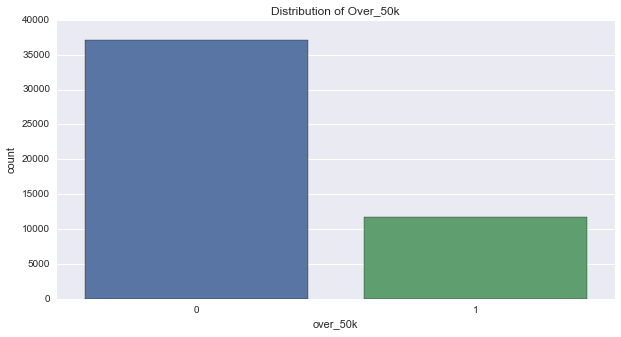

In [9]:
#Distribution of Over_50k
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='over_50k', data=records_joined)
plt.title('Distribution of Over_50k')

This in an of itself isn't that helpful though, at least from a modeling perspective, because we need to understand what is driving the *difference* between those making over 50k versus those making under 50k.  So let's also start looking at the predictor variables.  First, age.

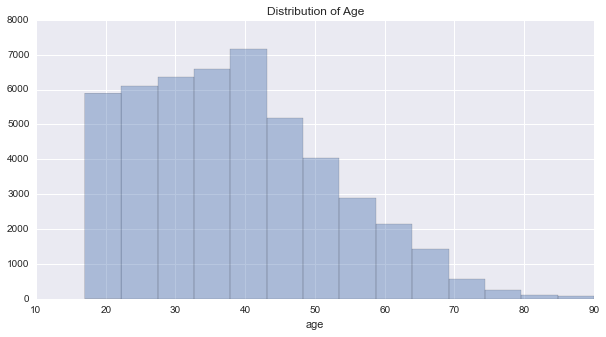

In [10]:
#Distribution of Age
f, ax = plt.subplots(figsize=(10, 5))
sns.distplot(records_joined.age, kde=False, bins=14)
plt.title('Distribution of Age')
#Note: 14 Bins returns five-year increments

The age of individuals in our data is centered around 35-40 and is heavily right-skewed, with observations as old as 90.  Next, let's look at how age plays a role in whether or not an individual exceeds the 50k benchmark.

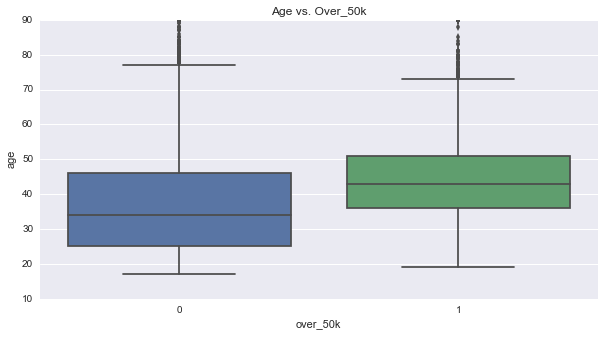

In [11]:
#Boxplot of over_50k by age
f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='over_50k', y='age', data=records_joined)
plt.title('Age vs. Over_50k')

Based on this boxplot, there appears to be an association between age and whether or not an individual makes over $50,000.  Generally speaking, it appears older individuals are somewhat more likely than younger individuals to exceed this threshold.  Next, let's start looking at our categorical variables by examining work class.

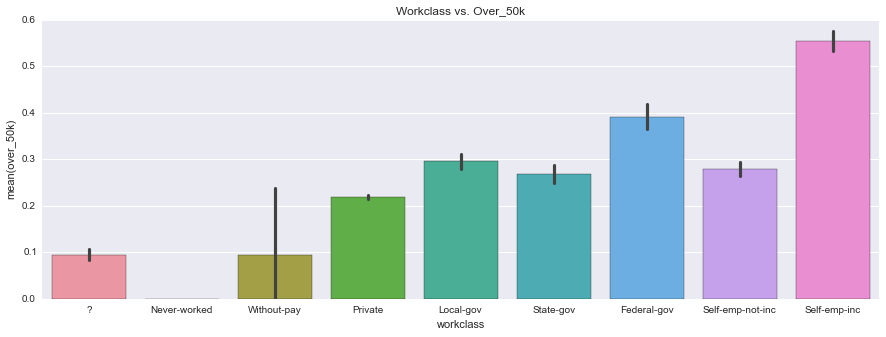

In [12]:
#Bar Chart - Percent of Each Work Class Exceeding 50k
f, ax = plt.subplots(figsize=(15, 5))
plt.title('Workclass vs. Over_50k')
sns.barplot(x='workclass', y='over_50k', data=records_joined, order=['?', 'Never-worked', 'Without-pay', 'Private', 'Local-gov', 
                                                                     'State-gov','Federal-gov', 'Self-emp-not-inc', 'Self-emp-inc'])

It appears some work classes are much more likely to make 50k than others, including "**self-emp-inc**."  What about education?

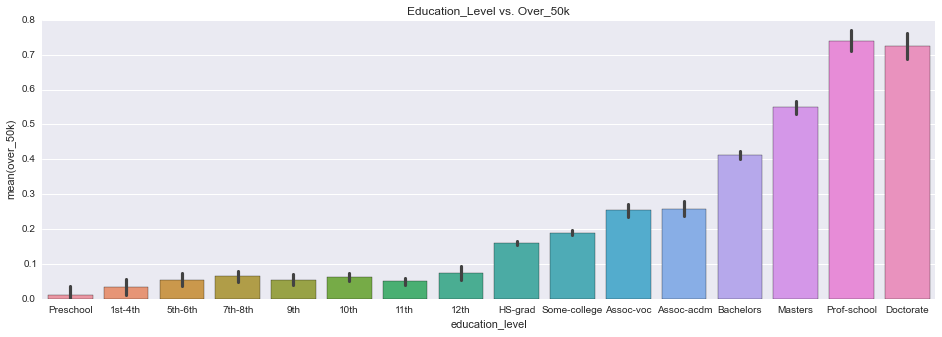

In [13]:
#Bar Chart - Percent of Each Education Level Exceeding 50k
f, ax = plt.subplots(figsize=(16, 5))
plt.title('Education_Level vs. Over_50k')
sns.barplot(x='education_level', y='over_50k', data=records_joined, order=['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', 
                                                                           '10th', '11th', '12th', 'HS-grad', 'Some-college', 
                                                                           'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 
                                                                           'Prof-school','Doctorate'])

This graph indicates that there is a strong positive association between the education level of an individual and whether or not he or she makes over 50k.  For example, according to our graph over **70%** of individuals with a professional degree or a doctorate make more than the threshold.  Conversely, Less than **10%** of individuals who failed finish high school (no matter the grade in which he or she dropped out) exceed $50,000 in annual income.  Expressed as a numeric variable, it appears as the following:

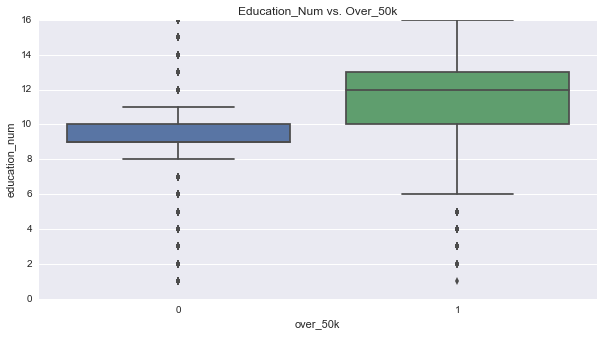

In [14]:
#Boxplot of over_50k by education_num
f, ax = plt.subplots(figsize=(10, 5))
plt.title('Education_Num vs. Over_50k')
sns.boxplot(x='over_50k', y='education_num', data=records_joined)

It's worth noting that the "**education_num**" variable is a numeric representation of the education level of an individual.  The variable value does not necessarily equate to years of schooling or anything like that--but higher numbers indicate additional education.  As you can see, users who make over 50k are generally more highly-educated than those that don't.  

It's also worth noting, that we will include *either* "**education_num**" *or* "**education_level**" in our model, but not both.  Since these variables convey the exact same information, we would be introducing multicollinearity if we retained both features.  As such, we will pick one to drop when we reach the modeling stage of our problem.

Next, marital status.

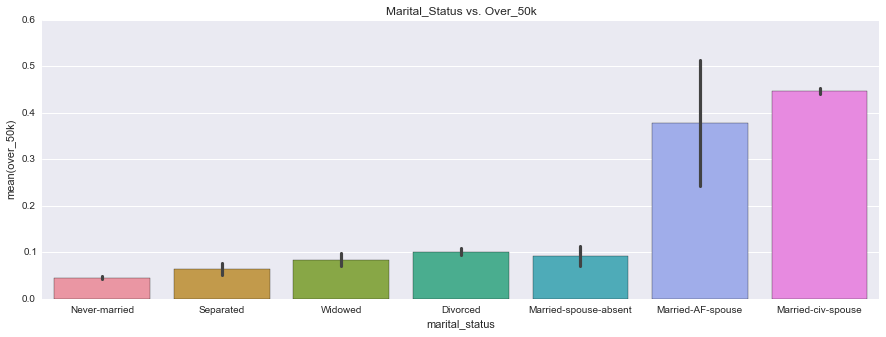

In [15]:
#Bar Chart - Percent of Each Marital Status Exceeding 50k
f, ax = plt.subplots(figsize=(15, 5))
plt.title('Marital_Status vs. Over_50k')
sns.barplot(x='marital_status', y='over_50k', data=records_joined, order=['Never-married', 'Separated', 'Widowed', 'Divorced',
                                                                         'Married-spouse-absent', 'Married-AF-spouse',
                                                                         'Married-civ-spouse'])

It appears that those who are happily married are much more likely to make over 50k (whether they are armed forces or civilians).  Note that the confidence interval for **"Married-AF-spouse"** is very wide because there are not many observations that fall into that category, so we are less certain of the true value of the population mean.  What about Job Type?

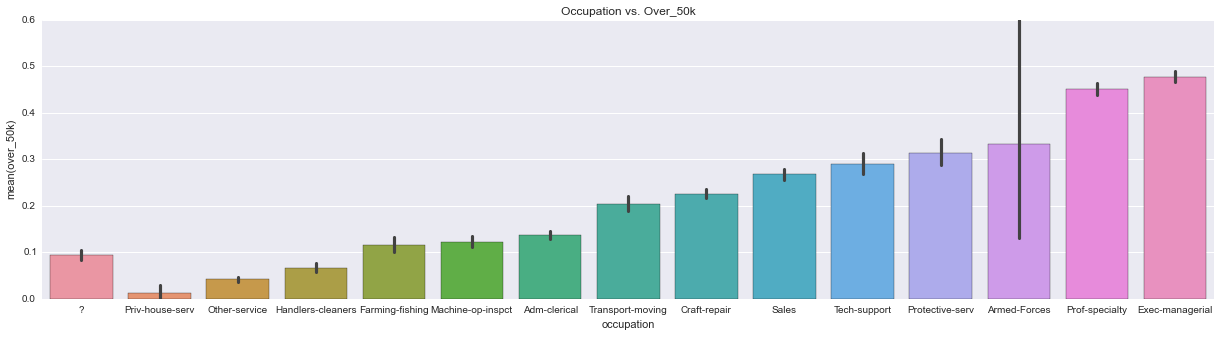

In [16]:
#Bar Chart - Percent of Each Occupation Exceeding 50k
f, ax = plt.subplots(figsize=(21, 5))
plt.title('Occupation vs. Over_50k')
sns.barplot(x='occupation', y='over_50k', data=records_joined, order=['?', 'Priv-house-serv', 'Other-service', 'Handlers-cleaners',
                                                                     'Farming-fishing', 'Machine-op-inspct','Adm-clerical', 
                                                                     'Transport-moving', 'Craft-repair', 'Sales', 'Tech-support',
                                                                     'Protective-serv', 'Armed-Forces', 'Prof-specialty', 'Exec-managerial'])

It seems job title seems to make a huge difference in terms of whether or not an individual makes more or less than the 50k benchmark. For instance, almost **half** of individuals in the "**Exec-managerial**" bucket exceed 50k in earnings whereas "**Handlers-cleaners**" only exceed the benchmark **7-8%** of the time.  Next, let's look at relationship status.

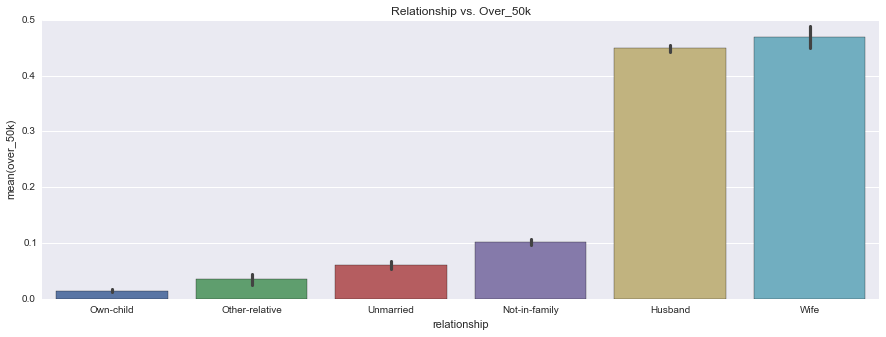

In [17]:
#Bar Chart - Percent of Each Relationship Status Exceeding 50k
f, ax = plt.subplots(figsize=(15, 5))
plt.title('Relationship vs. Over_50k')
sns.barplot(x='relationship', y='over_50k', data=records_joined, order=['Own-child', 'Other-relative', 'Unmarried', 'Not-in-family',
                                                                       'Husband', 'Wife'])

According to our graph, husbands and wives are significantly more likely to make at least 50k a year as compared to those individuals who are not married.  This reaffirms our findings earlier regarding marital status.  

*However*, I think this variable is a good candidate to be dropped from our model, and here's why.  Relationship in the way it is defined in this variable is defined by two main things: gender and marital status.  For the most part, these two factors define someone's relationship status.  Conveniently, we already have this information conveyed in the features "**sex**" and "**marital_status**" so including "**relationship**" in the model seems that it would be largely redundant and introduce collinearity.

Next, let's look at race.

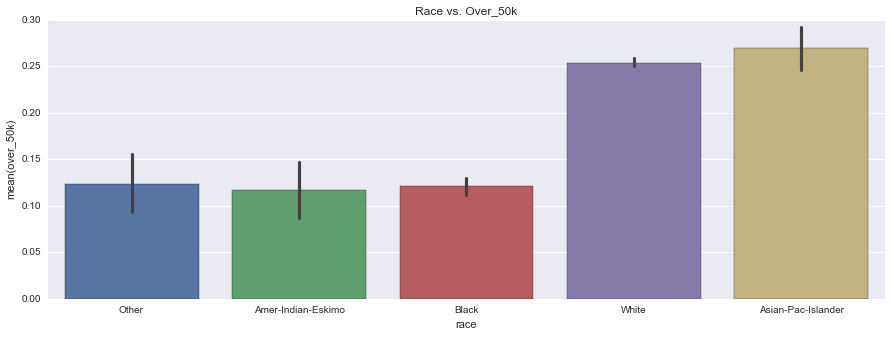

In [18]:
#Bar Chart - Percent of Each Race Exceeding 50k
f, ax = plt.subplots(figsize=(15, 5))
plt.title('Race vs. Over_50k')
sns.barplot(x='race', y='over_50k', data=records_joined, order=['Other', 'Amer-Indian-Eskimo', 'Black', 'White', 'Asian-Pac-Islander'])

Our chart indicates that individuals who are Asian/Pacific Islander or White are significantly more likely to make at least 50k than other ethnicities.  Next, let's look at gender breakdown.

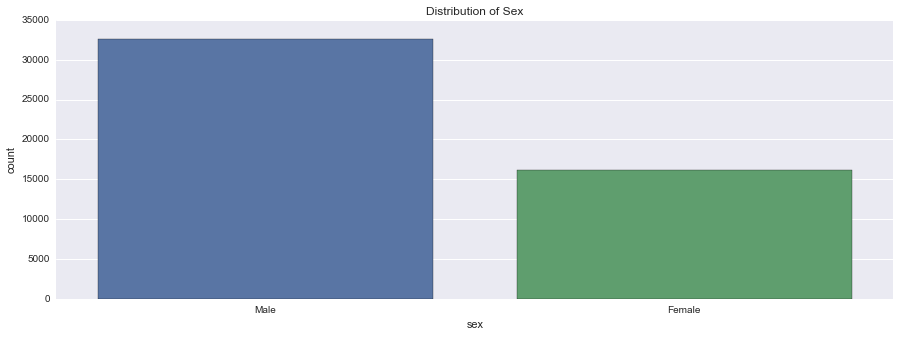

In [19]:
#Distribution of Sex
f, ax = plt.subplots(figsize=(15, 5))
plt.title('Distribution of Sex')
sns.countplot(x='sex', data=records_joined)

According to our the chart, our data set includes roughly twice as many male observations as female observations.

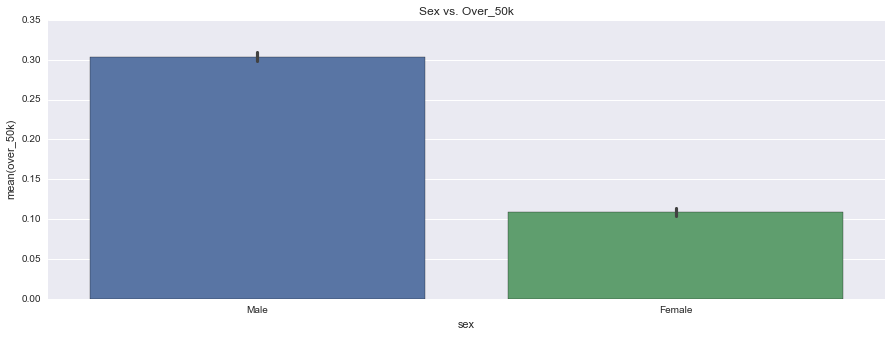

In [20]:
#Bar Chart - Percent of each Gender Exceeding 50k
f, ax = plt.subplots(figsize=(15, 5))
plt.title('Sex vs. Over_50k')
sns.barplot(x='sex', y='over_50k', data=records_joined)

Additionally, males appear more than twice as likely to earn more than $50,000, as over **30%** of men clear this benchmark whereas only **~11%** of women make that much.  Next, let's look at native country.

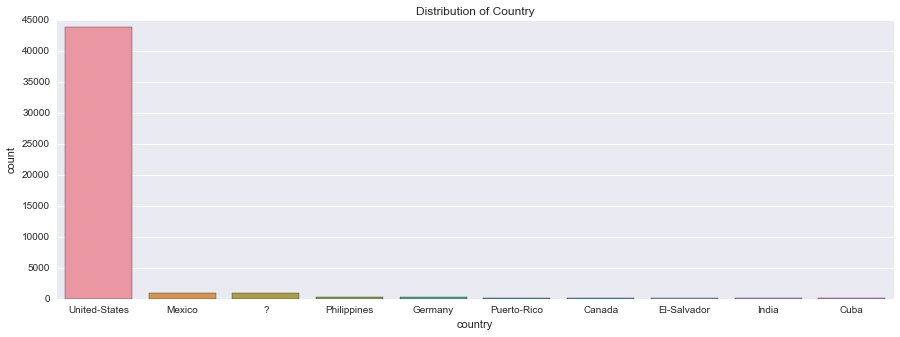

In [21]:
#Distribution of Native Country
country_count = records_joined['country'].value_counts() #Note this counts the number of occurences of each country

#Because there are so many countries represented (42!) we only want to graph the top 10
f, ax = plt.subplots(figsize=(15, 5))
plt.title('Distribution of Country')
sns.countplot(x="country", data=records_joined, order=country_count.index[0:10])

The United States is overwhelmingly the most-represented native country in our data set, comprising almost 90% of all observations.  Because there is such little variance to be captured in this variable, it will likely not be useful from a predictive modeling standpoint, so we will drop it from our feature matrix.  

Next let's look at the continuous variables, "**capital_gain**" and "**capital_loss**."

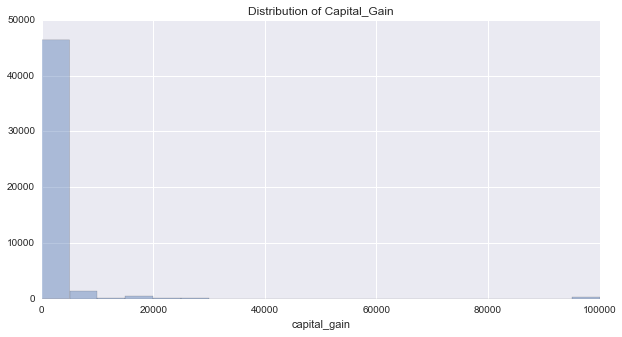

In [22]:
#Distribution of Capital Gain
f, ax = plt.subplots(figsize=(10, 5))
plt.title('Distribution of Capital_Gain')
sns.distplot(records_joined['capital_gain'], kde=False, bins=20)

As the graph demonstrates, over **90%** of the individuals in our data set had a $0 in capital gains.  Again, since there is very little variance to be captured by this variable, it will likely not be used in our model.

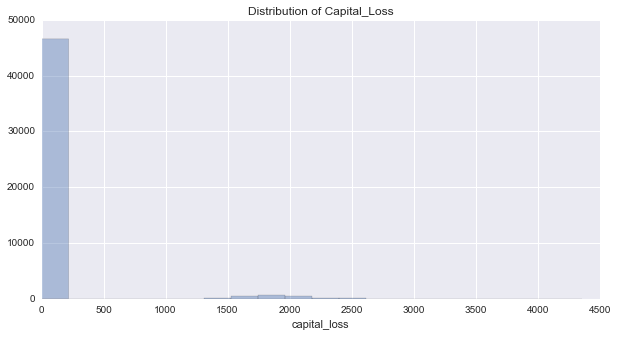

In [23]:
#Distribution of Capital Loss
f, ax = plt.subplots(figsize=(10, 5))
plt.title('Distribution of Capital_Loss')
sns.distplot(records_joined['capital_loss'], kde=False, bins=20)

Similarly, over **90%** of the individuals in our data set had a $0 in capital losses. As such, we will likely preclude this variable from our model.  Finally, let's look at hours per week and how that affects an individual's earnings.

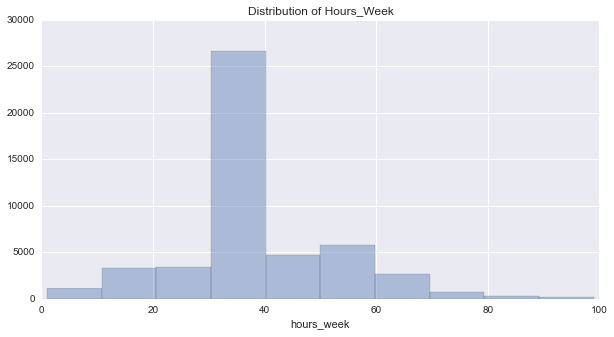

In [24]:
# Distribution of Hours per Week
f, ax = plt.subplots(figsize=(10, 5))
plt.title('Distribution of Hours_Week')
sns.distplot(records_joined['hours_week'], kde=False, bins=10)

According to our histogram, a huge proportion (almost half) of workers report 40 hour workweeks. However, many employees also report working longer hours, as the distribution appears slightly right-skewed.  Let's see how "**hours_week**" affects a worker's earnings.

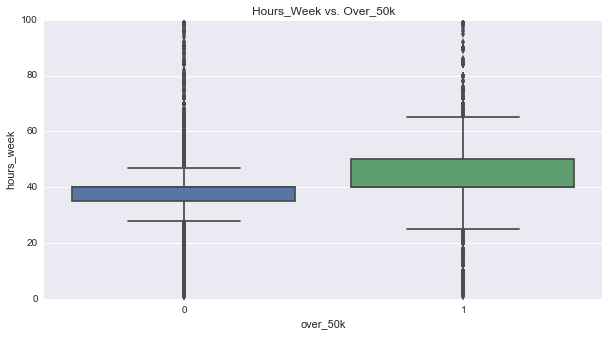

In [25]:
#Boxplot of over_50k by Hours per Week
f, ax = plt.subplots(figsize=(10, 5))
plt.title('Hours_Week vs. Over_50k')
sns.boxplot(x='over_50k', y='hours_week', data=records_joined)

Based on the chart, it appears there is a positive association between hours worked per week and an individual's ability to earn at least $50,000.

###Task 5:
**Split the data into training, validation, and test data sets.**

The scikit-learn cross validation module has a function called "train_test_split" that can split our data into training and validation sets with one line of code.  Below, we split out a 25% validation sample to evaluate our models.

In [26]:
# Split into Feature Matrix and Target Variable Array
from sklearn import cross_validation
y = records_joined['over_50k']
X = records_joined.drop(['over_50k'], axis=1)

# Split Training Data Into Training and Validation
X_train, X_validation, y_train, y_validation = cross_validation.train_test_split(X, y, test_size = 0.25, random_state = 5)

###Task 6:
**Develop a model that predicts whether individuals, based on the census variables provided, make over \$50,000/year.** 

First, we need to talk about *feature selection*.  As I've mentioned periodically throughout our descriptive statistics section above, several variables look like great candidates to be dropped from the model:
* "**education_level_id**"
  * This variable is perfectly correlated with the "**education_num**" variable.  As such, since both convey the exact same information, we can drop one.
* "**country_id**"
  * Since over 90% of the individuals in our sample are from the U.S. this variable likely provides little predictive power.
* "**relationship_id**"
  * Majority of the relevant information here is either captured by "**marital_status**" or "**sex**" so we can drop.
* "**capital_gain**"
  * Since over 90% of the individuals in our sample had no capital gains this variable likely provides little predictive power.
* "**capital_loss**"
  * Since over 90% of the individuals in our sample had no capital losses this variable likely provides little predictive power.
  
The code below removes these variables from both our training and validation data sets.

In [27]:
#Drops unwanted features from the model
X_train = X_train.drop(['education_level', 'country', 'relationship', 'capital_gain', 'capital_loss'], axis=1)
X_validation = X_validation.drop(['education_level', 'country', 'relationship', 'capital_gain', 'capital_loss'], axis=1)

#Show training data
X_train.head()

,age,workclass,education_num,marital_status,occupation,race,sex,hours_week
id,,,,,,,,
23659,48,Private,10,Divorced,Sales,White,Male,45
25433,48,Local-gov,13,Married-civ-spouse,Prof-specialty,White,Male,40
26887,48,State-gov,15,Married-civ-spouse,Prof-specialty,White,Male,50
38468,25,Federal-gov,10,Married-civ-spouse,Craft-repair,White,Male,40
37828,40,Private,14,Married-civ-spouse,Exec-managerial,White,Male,50


Unfortunately, Scikit-learn doesn't play nice with non-numeric data.  However, we can't just label each level of the categorical variables as integers, because then the model algorithm will treat those variables as continuous.  As such, we must encode these variables as *dummy variables*.  Below is some code that defines a function to do just that.  

In [28]:
# Create function to define dummy variables, drop the last dummy, add dummies to dataframe, and remove original variable
def dummy_code(df, column):
    dummies = pd.get_dummies(df[column], prefix=column)
    dummies = dummies.iloc[:, :len(dummies.columns)-1]
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

# Note: The reason we drop the last dummy variable is to avoid the so-called 'dummy variable trap' 

Now that we've defined our function, we can apply it to our model data as follows.

In [29]:
# Apply dummy variable coding
for column in ['workclass', 'marital_status', 'occupation', 'race', 'sex']:
    X_train = dummy_code(X_train, column)
    X_validation = dummy_code(X_validation, column)

# Show training data set with dummy coding
X_train.head()

,age,education_num,hours_week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,sex_Female
id,,,,,,,,,,,,,,,,,,,,,
23659,48,10,45,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
25433,48,13,40,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
26887,48,15,50,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
38468,25,10,40,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37828,40,14,50,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


So now all of our variables are numeric and also represent the original categorical variable.  We have our data ready for model building!

Three algorithms I like to use for classification problems are:
* Logistic Regression
* Random Forest
* K-Nearest Neighbor

An implementation of each of these algorithms is detailed below along with the model accuracy and c-statistic on our hold-out validation data set.

In [30]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Fit the Model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make Predictions (Validation Set)
logreg_pred = logreg.predict(X_validation)
print 'Logistic Regression Classification Accuracy: ' + str(metrics.accuracy_score(y_validation, logreg_pred))
logreg_pred_probs = logreg.predict_proba(X_validation)
print 'Logistic Regression Area Under the Curve: ' + str(metrics.roc_auc_score(y_validation, logreg_pred_probs[:,1]))

Logistic Regression Classification Accuracy: 0.835639996724
Logistic Regression Area Under the Curve: 0.883983605637


In [31]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Fit the Model
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)

# Make Predictions (Validation Set)
forest_pred = forest.predict(X_validation)
print 'Random Forest Classification Accuracy: ' + str(metrics.accuracy_score(y_validation, forest_pred))
forest_pred_probs = forest.predict_proba(X_validation)
print 'Random Forest Area Under the Curve: ' + str(metrics.roc_auc_score(y_validation, forest_pred_probs[:,1]))

Random Forest Classification Accuracy: 0.819752682008
Random Forest Area Under the Curve: 0.863620866849


In [32]:
# K-Nearest Neighbor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

# Instatiate KNN
knn = KNeighborsClassifier()

# Range of k's to try in Grid Search and Create Parameter Grid
k_range = range(1, 31)
param_grid = dict(n_neighbors = k_range)

# Instantiate the grid
# NOTE: I think I should really be training this on ALL the data instead of just the training data 
# since we are using cross-validation; however, I'm only doing this to get an idea of the best value of k
grid = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)
print grid.best_params_

# Make Predictions (Validation Set)
knn_pred = grid.predict(X_validation)
print 'K-Nearest Neighbor Classification Accuracy: ' + str(metrics.accuracy_score(y_validation, knn_pred))
knn_pred_probs = grid.predict_proba(X_validation)
print 'K-Nearest Neighbor Area Under the Curve: ' + str(metrics.roc_auc_score(y_validation, knn_pred_probs[:,1]))

{'n_neighbors': 28}
K-Nearest Neighbor Classification Accuracy: 0.825239538121
K-Nearest Neighbor Area Under the Curve: 0.865622178716


So it looks like of the three models we built that Logistic Regression had the best classification rate and also the largest area under the curve.  Let's take a look at the confusion matrix for that model.

In [33]:
# Logistic Regression Confusion Matrix
confusion = metrics.confusion_matrix(y_validation, logreg_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print confusion

[[8606  681]
 [1326 1598]]


Using the default classification threshold of 0.5, it appears we are predicting more *false-negatives* than *false-positives*.  This means that our **sensitivity** (our ability to correctly predict events) is lower than our **specificity** (our ability to correctly predict non-events).  The calculations for these statistics are below.

In [34]:
# Calculates Sensitivity and Specificity
sensitivity = float(TP)/(TP+FN)
specificity = float(TN)/(TN+FP)
print 'Sensitivity: ' + str(sensitivity)
print 'Specificity: ' + str(specificity)

Sensitivity: 0.546511627907
Specificity: 0.926671691612


A ROC Curve of our final model is demonstrated below.  This curve represents the trade-off between our ability to predict events (individuals making at least 50k) versus our ability to predict non-events (individuals making less than 50k).  If we wanted a more *sensitive* model, we could decrease the classification threshold; however, this would lower the *specificity* or selectiveness of our model.

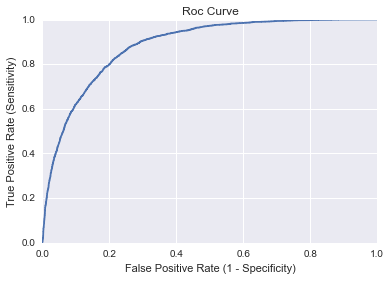

In [35]:
# Draws ROC Curve for our Logistic Regression Model
fpr, tpr, thresholds = metrics.roc_curve(y_validation, logreg_pred_probs[:,1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Roc Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

### Summary:
Using the data provided, we have created three models that can correctly identify an individual's income class (under 50k or over 50k) over 80% of the time using the following eight variables:
  * Age
  * Education_Num
  * Hours_Week
  * Workclass
  * Marital_Status
  * Occupation
  * Race
  * Sex
  
On holdout validation data, our best model correctly classifies ~55% of individuals who actually make more than \$50,000 and  ~93% of individuals who make less than $50,000.

### Areas for Further Research:
There are a few other procedures that may improve the quality of our model that can be looked into as areas of potential improvement.
  * **Box-Tidwell Test for Logit Linearity:**
   * The Box-Tidwell transformation helps test the assumption of logit linearity for continuous variables in a logistic regression model.  To avoid this assumption, one could try "binning" continuous variables.  Currently, our model does not test this assumption or bin continuous variables, so this is an area of potential improvement.
  * **Use the Youden Statistic to Optimize Sensitivity & Specificity:**
   * Currently, the classification threshold for our models is set to the default value (0.5).  A suggestion for improvement would be to calculate the Youden Statistic, which optimizes this threshold for the best tradeoff between sensitivity and specificity by setting them equal to each other.  Using this classification cut-off, we may improve the accuracy of our model. 
  * **Ensemble Our Models:**
   * Rather than selecting the highest-performing model and using that to make predictions, we can combine our models together to instead create an ensemble model.  By doing so, each model would contribute to the predictions for each observation, and it could improve our final model accuracy.  We could do this in two ways:
     * Average the probability for each observation across our three initial models, and use this new probability to make classification decisions
     * Have our three initial models "vote" on the classification of each observation, and use the mode.
     
Thanks for reading and please feel free to reach me at **richard_conboy@ncsu.edu** or **845-264-2406** with any questions!